# Federated Learning with TensorFlow

#### This notebook presents a simple example / application of federated learning on developing a Machine Learning model for Intrusion Detection for defending against Cyberattacks.
#### This example uses Docker containers as independent workers / clients for performing the client model training on the limited local client data.
#### This example was developed as part of the research conducted at MetaMind Innovations in the framework of the [AI4CYBER](http://metamind.gr/portfolio-items/ai4cyber-horizon-europe/) project.

## Set Up TFF Environment

In [1]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade tensorflow
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet --upgrade pandas
!pip install --quiet --upgrade matplotlib

In [2]:
import collections
import os
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import time

from matplotlib import pyplot as plt

import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

2022-11-07 21:30:21.037065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 21:30:21.117197: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-07 21:30:21.120494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-07 21:30:21.120505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

Print a "Hello World" message through TFF to verify the proper TFF installation

In [3]:
tff.federated_computation(lambda: 'Hello, World!')()

2022-11-07 21:30:22.642739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-07 21:30:22.642767: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-07 21:30:22.642783: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mmu): /proc/driver/nvidia/version does not exist
2022-11-07 21:30:22.642985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


b'Hello, World!'

## Dataset

This dataset is part of the [IEC 60870-5-104 Intrusion Detection Dataset](http://zenodo.org/record/7108614#.YzGaDtJBwUE) -- DOI: [10.1109/TII.2021.3093905](http://doi.org/10.1109/TII.2021.3093905) -- published by [ITHACA – University of Western Macedonia](http://ithaca.ece.uowm.gr/).

We input the dataset path and choose which dataset to facilitate for the experimentation.

We also input the number of clients / workers that we are going to use. We can use $2 \leq N \leq 5$ individual workers.

For this example we use the CICFlowMeter dataset with capturing timeout at 180 seconds with 2 distinct workers.

In [4]:
path = '~/workspace/datasets/Balanced_IEC104_Train_Test_CSV_Files/iec104_train_test_csvs'
tp = 'cic'      # Type: choose between 'cic' and 'custom'
tm = 180        # Timeout: choose one value from the following list [15, 30, 60, 90, 120, 180]
n_workers = 2   # #workers: choose between 2 and 5 workers (2 and 5 inclusive)

Perform some input value checks.

In [5]:
assert tp in ('cic', 'custom'), "Wrong dataset type"
assert tm in (15, 30, 60, 90, 120, 180), "Wrong time"
assert 2 <= n_workers <= 5, "At least 2 and at most 5 workers (docker containers) are required"

In [6]:
dataset = f'tests_{tp}_{tm}'

if 'cic' in dataset:
    n = dataset.split('_')[-1]
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_cicflow.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_cicflow.csv')
elif 'custom' in dataset:
    n = dataset.split('_')
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_custom_script.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_custom_script.csv')
else:
    raise Exception("Wrong dataset")

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(train_csv)

Let's perform some data exploration.

In [7]:
df_train.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max       int64
Idle Min       int64
Label         object
Length: 84, dtype: object

In [8]:
df_test.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max       int64
Idle Min       int64
Label         object
Length: 84, dtype: object

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

As a preprocessing step, we transorm the "Label" feature from string to categorical and then to numeric.

In [11]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

In [12]:
unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

In [13]:
mapping

{11: 'normal',
 0: 'c_ci_na_1',
 1: 'c_ci_na_1_dos',
 2: 'c_rd_na_1',
 3: 'c_rd_na_1_dos',
 4: 'c_rp_na_1',
 5: 'c_rp_na_1_dos',
 6: 'c_sc_na_1',
 7: 'c_sc_na_1_dos',
 8: 'c_se_na_1',
 9: 'c_se_na_1_dos',
 10: 'm_sp_na_1_dos'}

In [14]:
df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)

Now, we remove the features which do not assist with training a ML model.

In [15]:
if tp == 'cic':
    train = df_train.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])
    test = df_test.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp'])
else:
    train = df_train
    test = df_test

Each worker will be assigned a subset of the dataset with $\lfloor {M \over N} \rfloor$ data points.

In [16]:
n_samples = int(df_train.shape[0] / n_workers)

assert n_samples > 0, "Each worker must be assigned at least one data point"

As a preprocessing step, for every client individually, we randomly choose N samples from the client's subset, flatten and shuffle it.

In [17]:
n_epochs = 10
shuffle_buffer_size = df_train.shape[0]
batch_size = 250
prefetch_buffer_size = 50
input_shape = train.shape[1] - 1
output_shape = len(unique_codes)

In [18]:
def preprocess(dataframe):
    
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    def map_fn(dataset):
        return collections.OrderedDict(
            x=tf.cast(dataset[:,:-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:,-1], shape=(-1, 1)), tf.int64)
        )

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size).batch(batch_size).map(map_fn).prefetch(prefetch_buffer_size)


client_data = [preprocess(train.sample(n=n_samples)) for _ in range(n_workers)]

In [19]:
client_data

[<PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 76), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 76), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>]

In [20]:
print(len(client_data[0]))
print(len(client_data[1]))

72
72


Let's perform some statistical analysis on the difference in the number of samples for each digit in each client dataset.

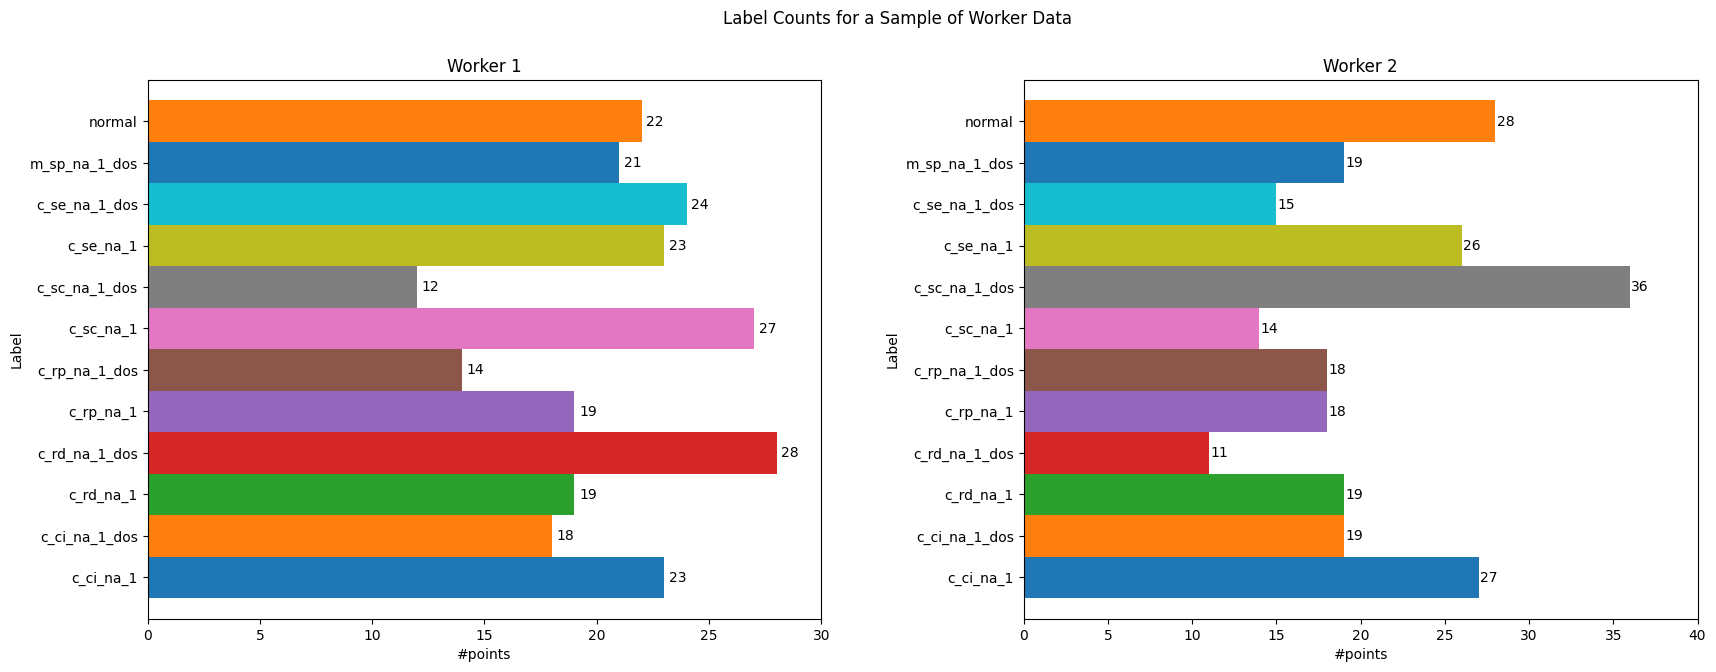

In [21]:
# Number of examples per layer for a sample of clients
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    for label in list(client_data[i])[0]['y'].numpy()[:,0]:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(5-m%5)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+0.6, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

## Define the Model to Train

The model we use is a simple MLP with one hidden layer.

In [22]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_shape,)),
        tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
        tf.keras.layers.Softmax(),
    ])
    return tff.learning.from_keras_model(model,
        # Note: input spec is the _batched_ shape, and includes the 
        # label tensor which will be passed to the loss function. This model is
        # therefore configured to accept data _after_ it has been preprocessed.
        input_spec=collections.OrderedDict(
            x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
            y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [23]:
print(trainer.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[76,12],
      float32[12]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64
  >
>@SERVER)


In [24]:
def evaluate(num_rounds=10):    
    state = trainer.initialize()
    for round in range(num_rounds):
        t1 = time.time()
        result = trainer.next(state, client_data)
        state = result.state
        train_metrics = result.metrics['client_work']['train']
        t2 = time.time()
        print('Round {}: loss {}, round time {}'.format(
            round+1, train_metrics['loss'], t2 - t1))

## Set Up the Remote Executors

By default, TFF executes all computations locally. In this step we tell TFF to connect to another (set of) client(s).

Verify the integrity of the IP address(es) and port(s) before initiating connection and training.

In [25]:
import grpc

ip_address = ['0.0.0.0'] * n_workers  #@param {type:"string"}
ports = [80+i for i in range(n_workers)]  #@param {type:list["integer"]}

channels = [grpc.insecure_channel(f'{ip_address[i]}:{ports[i]}') for i in range(len(ports))]

tff.backends.native.set_remote_python_execution_context(channels)

### Launch N TFF workers as Docker Containers locally

```
docker run --rm -p 80:8000 -v /home/:/home/ gcr.io/tensorflow-federated/remote-executor-service:latest
docker run --rm -p 81:8000 -v /home/:/home/ gcr.io/tensorflow-federated/remote-executor-service:latest
docker run --rm -p 82:8000 -v /home/:/home/ gcr.io/tensorflow-federated/remote-executor-service:latest
...
```


Or use the **docker-compose.yaml** file to launch $2 \leq N \leq 5$ TFF workers as Docker Containers locally
```
docker compose up --scale tff=2
```

## Run Training

In [26]:
evaluate(n_epochs)

Round 1: loss 2.4849064350128174, round time 0.8322305679321289
Round 2: loss 2.4849064350128174, round time 0.4306950569152832
Round 3: loss 2.4849064350128174, round time 0.4070909023284912
Round 4: loss 2.4849064350128174, round time 0.3699955940246582
Round 5: loss 2.4849064350128174, round time 0.44867420196533203
Round 6: loss 2.4849064350128174, round time 0.3896756172180176
Round 7: loss 2.4849064350128174, round time 0.46233129501342773
Round 8: loss 2.4849064350128174, round time 0.41034626960754395
Round 9: loss 2.4849064350128174, round time 0.37673377990722656
Round 10: loss 2.4849064350128174, round time 0.3672010898590088


Obviously the training evaluation results are not that great, but further optimization and hyperparameters fine-tuning can be done.